# Quantitative analysis of storm, dynamo and scvelo methods on bifurcated simulation data

Here we will show the results of the quantitative comparison of storm, dynamo, scvelo and celldancer on a one-shot bifurcated simulation data.

In [1]:
import numpy as np
import scvelo as scv
import dynamo as dyn
import celldancer as cd
import pandas as pd


np.random.seed(0)

import anndata as ad
from scipy.sparse import csr_matrix

## Generate simulation data and pre-process

In [2]:
def make_sto_sim(alpha, beta, gamma, t_obs, labeling_time):
    # Simulate chemical master equation using Gillespie algorithm
    t_cur = 0.0
    u_cur = 0
    s_cur = 0
    ul_cur = 0
    sl_cur = 0

    while (t_cur < t_obs):
        a0 = alpha + beta * u_cur + gamma * s_cur
        delta_t = np.random.exponential(scale=1 / a0)
        t_cur = t_cur + delta_t
        if t_cur > t_obs:
            break
        temp = np.random.rand()
        if temp < (alpha / a0):
            if t_cur > (t_obs - labeling_time):
                ul_cur = ul_cur + 1
            u_cur = u_cur + 1
        elif temp >= (alpha / a0) and temp < (alpha + beta * u_cur) / a0:
            if t_cur > (t_obs - labeling_time):
                if np.random.rand() < (ul_cur / u_cur):
                    ul_cur = ul_cur - 1
                    sl_cur = sl_cur + 1
            u_cur = u_cur - 1
            s_cur = s_cur + 1
        else:
            if t_cur > (t_obs - labeling_time):
                if np.random.rand() < (sl_cur / s_cur):
                    sl_cur = sl_cur - 1
            s_cur = s_cur - 1

    return u_cur, s_cur, ul_cur, sl_cur, alpha, beta, gamma

In [3]:
n_gene = 1000
n_obs = 1200
T = 20 # max observation time
unspliced = np.zeros((n_obs, n_gene))
spliced = np.zeros((n_obs, n_gene))
ul = np.zeros((n_obs, n_gene))
sl = np.zeros((n_obs, n_gene))
alpha_obs = np.zeros((n_obs, n_gene))
beta = np.random.rand(n_gene) * 5
gamma = 0.5 * np.random.rand(n_gene) + 0.01

labeling_time = 1.0 * np.ones(n_obs) # labeling time

In [4]:
# Generate simulated data for bifurcation starting at T/2
t_branch = T/2
t_obs = np.zeros(n_obs)
t_obs[0: int(n_obs/2)] = np.sort(np.random.rand(int(n_obs/2)) * (1 - 1. / t_branch) * t_branch + 1.)
t_obs[int(n_obs/2):int(n_obs/4*3)] = np.sort(np.random.rand(int(n_obs/4*3)-int(n_obs/2)) * (1 - t_branch / T) * (T-t_branch) + t_branch)
t_obs[int(n_obs/4*3):] = np.sort(np.random.rand(n_obs-int(n_obs/4*3)) * (1 - t_branch / T) * (T-t_branch) + t_branch)

In [5]:
# We followed velosim to generate EVFs and gene factors used to calculate transcription rates
EVF = np.zeros((10, n_obs))
for i in range(n_obs):
    if i==0:
        EVF[:, 0] = 1.0
    elif i < int(n_obs / 2):
        EVF[:, i] = EVF[:, i-1] + np.random.randn(10) * (t_obs[i] - t_obs[i - 1])
    elif i>=int(n_obs/2) and i < int(n_obs/4*3):
        EVF[:, i] = EVF[:, i-1] + np.random.randn(10) * (t_obs[i]-t_obs[i-1])
    elif i >= int(n_obs/4*3):
        if i == int(n_obs/4*3):
            EVF[:, i] = EVF[:, int(n_obs / 2)-1] + np.random.randn(10) * (t_obs[i]-t_obs[int(n_obs / 2)-1])
        else:
            EVF[:, i] = EVF[:, i - 1] + np.random.randn(10) * (t_obs[i] - t_obs[i - 1])

gene_factor = np.zeros((n_gene, 10))
index_no_zero = np.zeros_like(gene_factor, dtype=bool)
for k in range(n_gene):
    index_no_zero[k, :] = np.random.rand(10) > 0.7
gene_factor[index_no_zero] = np.random.randn(np.sum(index_no_zero))
alpha = np.dot(gene_factor, EVF).T
# scale to normal range
for k in range(n_gene):
    alpha[:, k] = (alpha[:, k] - np.min(alpha[:, k]))/(np.max(alpha[:, k]) - np.min(alpha[:, k])) + 0.05

In [6]:
# run Gillespie algorithm
for i in range(n_gene):
    for j in range(n_obs):
        unspliced_i_j, spliced_i_j, ul_i_j, sl_i_j, alpha_i_j, gamma_i, beta_i = make_sto_sim(alpha=alpha[j, i],
                                                                                                  beta=beta[i],
                                                                                                  gamma=gamma[i],
                                                                                                  t_obs=t_obs[j],
                                                                                                  labeling_time=
                                                                                                  labeling_time[j])
        unspliced[j, i], spliced[j, i], ul[j, i], sl[j, i], alpha_obs[j, i] = \
            unspliced_i_j, spliced_i_j, ul_i_j, sl_i_j, alpha_i_j

In [7]:
# generate adata
uu = csr_matrix(unspliced - ul)
su = csr_matrix(spliced - ul)
ul = csr_matrix(ul)
sl = csr_matrix(sl)
adata = ad.AnnData(uu + su + ul + sl)
adata.layers['uu'] = uu
adata.layers['su'] = su
adata.layers['ul'] = ul
adata.layers['sl'] = sl
adata.obs['time'] = labeling_time
adata.obs['obs_time'] = t_obs
adata.obs['order'] = np.arange(n_obs)
adata.var['true_gamma'] = gamma

# technical noise is not considered, so the size factor is set to 1
cell_total = (uu + ul + su + sl).sum(axis=1).A1
adata.obs['Size_Factor'] = np.ones_like(labeling_time)
adata.obs['initial_cell_size'] = np.ones_like(labeling_time) * np.median(cell_total)
adata.obs['total_Size_Factor'] = adata.obs['Size_Factor']
adata.obs['initial_total_cell_size'] = adata.obs['initial_cell_size']
adata.obs['new_Size_Factor'] = adata.obs['Size_Factor']
adata.obs['initial_new_cell_size'] = adata.obs['initial_cell_size']
adata.obs['spliced_Size_Factor'] = adata.obs['Size_Factor']
adata.obs['initial_spliced_cell_size'] = adata.obs['initial_cell_size']
adata.obs['unspliced_Size_Factor'] = adata.obs['Size_Factor']
adata.obs['initial_unspliced_cell_size'] = adata.obs['initial_cell_size']
adata.obs['uu_Size_Factor'] = adata.obs['Size_Factor']
adata.obs['initial_uu_cell_size'] = adata.obs['initial_cell_size']
adata.obs['ul_Size_Factor'] = adata.obs['Size_Factor']
adata.obs['initial_ul_cell_size'] = adata.obs['initial_cell_size']
adata.obs['su_Size_Factor'] = adata.obs['Size_Factor']
adata.obs['initial_su_cell_size'] = adata.obs['initial_cell_size']
adata.obs['sl_Size_Factor'] = adata.obs['Size_Factor']
adata.obs['initial_sl_cell_size'] = adata.obs['initial_cell_size']

In [8]:
# pre-process
import dynamo as dyn

dyn.pp.recipe_monocle(
    adata,
    tkey="time",
    experiment_type="one-shot",
    # experiment_type="kin",
    n_top_genes=1000,
    # total_layers=False,
    keep_raw_layers=True,
    # feature_selection_layer="new",
    keep_filtered_genes=False,
)

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----> detected experiment type: one-shot
|-----------> <insert> tkey to uns['pp'] in AnnData Object.
|-----------> <insert> experiment_type to uns['pp'] in AnnData Object.
|-----> filtering cells...
|-----> <insert> pass_basic_filter to obs in AnnData Object.
|-----> 1200 cells passed basic filters.
|-----> filte

In [9]:
dyn.tl.moments(adata)
adata.layers['M_u'] = adata.layers['M_u'].toarray()
adata.layers['M_s'] = adata.layers['M_s'].toarray()
adata.obsm['X_pca_2d'] = adata.obsm['X_pca'][:, 0:2]
adata.var_names = 'gene' + adata.var_names
adata.obs_names = 'cell' + adata.obs_names
adata.layers['true_alpha'] = alpha

|-----> calculating first/second moments...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [8.6961s]


## Use Storm, Dynamo, scVelo and cellDancer methods to infer parameters and calculate total velocity, respectively.

In [10]:
adata_dynamo = adata.copy()
adata_celldancer = adata.copy()

scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
adata.layers['Ms'] = adata.layers['M_s'].copy()
adata.layers['Mu'] = adata.layers['M_u'].copy()
scv.tl.recover_dynamics(adata, var_names='all', max_iter=50, t_max=False)
adata_storm = adata.copy()
# adata_scvelo = adata.copy()
del adata

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/12 cores)


  0%|          | 0/1000 [00:00<?, ?gene/s]

    finished (0:03:05) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [11]:
# for Storm 
adata_storm.uns["pp"]["experiment_type"] = 'kin'
dyn.tl.dynamics(adata_storm,
                model="deterministic",
                est_method='osnoss',
                )
from CSP4ML import select_scv_genes
select_scv_genes(adata_storm)
r2_thr = np.quantile(adata_storm.var['no_linear_r2'].values, 0.8)
dyn.tl.reduceDimension(adata_storm, reduction_method='umap')
dyn.tl.cell_velocities(adata_storm, enforce=True, vkey='velocity_T', ekey='M_t', basis='pca',
                       transition_genes=list(set(adata_storm.var_names[adata_storm.var['no_linear_r2'] > r2_thr] &
                                                 set(adata_storm.var_names[adata_storm.var['gamma_r2'] > 0]))))

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----? You used tkey time (or group None), but you have calculated local smoothing (1st moment) for your data before. Please ensure you used the desired tkey or group when the smoothing was performed. Try setting re_smooth = True if not sure.
|-----> experiment type: kin, method: osnoss, model: deterministic


Estimate gamma via linear regression of t vs. -ln(1-K): 967it [00:00, 1660.88it/s]
Infer parameters via maximum likelihood estimation based on the ICSP model and scVelo: 967it [00:00, 1187.67it/s]


(967, 1)


select scvelo gene: 1000it [00:00, 4778.47it/s]

|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...


|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [5.7273s]
|-----? 
Your data has both labeling / splicing data, please ensuring using the right `basis` ({basis}):
   when using `velocity_S`, please use basis based on X_spliced data;
   when using `velocity_T, please use basis based X_total. 
If not sure the data in adata.X, you may need to set `basis='X_spliced_umap'`(`basis='X_total_umap'`) when using `velocity_S` (`velocity_T`). 
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [0.6847s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.3355s]


AnnData object with n_obs × n_vars = 1200 × 1000
    obs: 'time', 'obs_time', 'order', 'Size_Factor', 'initial_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'uu_Size_Factor', 'initial_uu_cell_size', 'ul_Size_Factor', 'initial_ul_cell_size', 'su_Size_Factor', 'initial_su_cell_size', 'sl_Size_Factor', 'initial_sl_cell_size', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'ntr', 'n_counts'
    var: 'true_gamma', 'nCells', 'nCounts', 'pass_basic_filter', 'use_for_pca', 'frac', 'ntr', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'alpha', 'a', 'b', 'alpha_a', 'alpha_i', 'beta', 'p_half_life', 'gamma', 'half_life', 'cost', 'logLL', 'gamma_k', 'gamma_r2', 'use_for_dynamics', 'no_l

In [12]:
# for dynamo
dyn.tl.dynamics(adata_dynamo,
                model="deterministic",
                )
dyn.tl.reduceDimension(adata_dynamo, reduction_method='umap')
dyn.tl.cell_velocities(adata_dynamo, enforce=True, vkey='velocity_T', ekey='M_t', basis='pca')

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----? You used tkey time (or group None), but you have calculated local smoothing (1st moment) for your data before. Please ensure you used the desired tkey or group when the smoothing was performed. Try setting re_smooth = True if not sure.


estimating alpha: 100%|████████████████████| 967/967 [00:00<00:00, 82840.93it/s]


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [4.5860s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----? 
Your data has both labeling / splicing data, please e

AnnData object with n_obs × n_vars = 1200 × 1000
    obs: 'time', 'obs_time', 'order', 'Size_Factor', 'initial_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'uu_Size_Factor', 'initial_uu_cell_size', 'ul_Size_Factor', 'initial_ul_cell_size', 'su_Size_Factor', 'initial_su_cell_size', 'sl_Size_Factor', 'initial_sl_cell_size', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'ntr'
    var: 'true_gamma', 'nCells', 'nCounts', 'pass_basic_filter', 'use_for_pca', 'frac', 'ntr', 'alpha', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'beta_k', 'gamma_k', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'dynamics', 'ne

In [13]:
# for celldancer
import celldancer.utilities as cdutil
cell_type_u_s = cdutil.adata_to_df_with_embed(adata_celldancer,
                              us_para=['M_u','M_s'],
                              cell_type_para='obs_time',
                              embed_para='X_pca_2d',
                              # save_path='cell_type_u_s.csv',
                              )
loss_df, cellDancer_df=cd.velocity(cell_type_u_s, 
                                   permutation_ratio=0.125,
                                   max_epoches=200,
                                   gene_list=list(adata_celldancer.var_names[adata_celldancer.var.use_for_pca]), 
                                   n_jobs=4)
cellDancer_df=cd.compute_cell_velocity(cellDancer_df=cellDancer_df)
cd.export_velocity_to_dynamo(cellDancer_df, adata_celldancer)
adata_celldancer = adata_celldancer[:, adata_celldancer.var.use_for_pca]
adata_celldancer_temp = cd.to_dynamo(cellDancer_df)

adata_celldancer.layers['velocity_S'] = pd.DataFrame(adata_celldancer_temp.layers['velocity_S'], 
                                        index=adata_celldancer_temp.obs.index, columns=adata_celldancer_temp.var.index).loc[adata_celldancer.obs.index, adata_celldancer.var.index]
adata_celldancer.layers['alpha'] = pd.DataFrame(adata_celldancer_temp.layers['alpha'], 
                                        index=adata_celldancer_temp.obs.index, columns=adata_celldancer_temp.var.index).loc[adata_celldancer.obs.index, adata_celldancer.var.index]
adata_celldancer.layers['beta'] = pd.DataFrame(adata_celldancer_temp.layers['beta'], 
                                        index=adata_celldancer_temp.obs.index, columns=adata_celldancer_temp.var.index).loc[adata_celldancer.obs.index, adata_celldancer.var.index]
adata_celldancer.layers['gamma'] = pd.DataFrame(adata_celldancer_temp.layers['gamma'], 
                                        index=adata_celldancer_temp.obs.index, columns=adata_celldancer_temp.var.index).loc[adata_celldancer.obs.index, adata_celldancer.var.index]
adata_celldancer.uns["dynamics"] = {}
adata_celldancer.uns["dynamics"]["has_splicing"] = True
adata_celldancer.uns["dynamics"]["has_labeling"] = False
dyn.tl.reduceDimension(adata_celldancer, reduction_method='umap')
dyn.tl.cell_velocities(adata_celldancer, enforce=False, vkey='velocity_S', ekey='M_s', basis='pca')

processing:1/1000
processing:2/1000
processing:3/1000
processing:4/1000
processing:5/1000
processing:6/1000
processing:7/1000
processing:8/1000
processing:9/1000
processing:10/1000
processing:11/1000
processing:12/1000
processing:13/1000
processing:14/1000
processing:15/1000
processing:16/1000
processing:17/1000
processing:18/1000
processing:19/1000
processing:20/1000
processing:21/1000
processing:22/1000
processing:23/1000
processing:24/1000
processing:25/1000
processing:26/1000
processing:27/1000
processing:28/1000
processing:29/1000
processing:30/1000
processing:31/1000
processing:32/1000
processing:33/1000
processing:34/1000
processing:35/1000
processing:36/1000
processing:37/1000
processing:38/1000
processing:39/1000
processing:40/1000
processing:41/1000
processing:42/1000
processing:43/1000
processing:44/1000
processing:45/1000
processing:46/1000
processing:47/1000
processing:48/1000
processing:49/1000
processing:50/1000
processing:51/1000
processing:52/1000
processing:53/1000
pr

processing:417/1000
processing:418/1000
processing:419/1000
processing:420/1000
processing:421/1000
processing:422/1000
processing:423/1000
processing:424/1000
processing:425/1000
processing:426/1000
processing:427/1000
processing:428/1000
processing:429/1000
processing:430/1000
processing:431/1000
processing:432/1000
processing:433/1000
processing:434/1000
processing:435/1000
processing:436/1000
processing:437/1000
processing:438/1000
processing:439/1000
processing:440/1000
processing:441/1000
processing:442/1000
processing:443/1000
processing:444/1000
processing:445/1000
processing:446/1000
processing:447/1000
processing:448/1000
processing:449/1000
processing:450/1000
processing:451/1000
processing:452/1000
processing:453/1000
processing:454/1000
processing:455/1000
processing:456/1000
processing:457/1000
processing:458/1000
processing:459/1000
processing:460/1000
processing:461/1000
processing:462/1000
processing:463/1000
processing:464/1000
processing:465/1000
processing:466/1000


processing:827/1000
processing:828/1000
processing:829/1000
processing:830/1000
processing:831/1000
processing:832/1000
processing:833/1000
processing:834/1000
processing:835/1000
processing:836/1000
processing:837/1000
processing:838/1000
processing:839/1000
processing:840/1000
processing:841/1000
processing:842/1000
processing:843/1000
processing:844/1000
processing:845/1000
processing:846/1000
processing:847/1000
processing:848/1000
processing:849/1000
processing:850/1000
processing:851/1000
processing:852/1000
processing:853/1000
processing:854/1000
processing:855/1000
processing:856/1000
processing:857/1000
processing:858/1000
processing:859/1000
processing:860/1000
processing:861/1000
processing:862/1000
processing:863/1000
processing:864/1000
processing:865/1000
processing:866/1000
processing:867/1000
processing:868/1000
processing:869/1000
processing:870/1000
processing:871/1000
processing:872/1000
processing:873/1000
processing:874/1000
processing:875/1000
processing:876/1000



Velocity Estimation:   1%|          | 2/242 [00:10<19:41,  4.92s/it]            /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.app


Velocity Estimation:   2%|▏         | 5/242 [00:19<12:33,  3.18s/it]            /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:   3%|▎         | 8/242 [00:25<09:01,  2.31s/it]            /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:   4%|▎         | 9/242 [00:28<09:19,  2.40s/it]            /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:   4%|▍         | 10/242 [00:30<08:43,  2.26s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:   5%|▌         | 13/242 [00:37<09:15,  2.43s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:   6%|▌         | 15/242 [00:41<08:25,  2.22s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:   7%|▋         | 17/242 [00:45<08:06,  2.16s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:   8%|▊         | 20/242 [00:53<08:36,  2.33s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:   9%|▉         | 22/242 [00:57<08:07,  2.22s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  10%|▉         | 24/242 [01:01<08:02,  2.21s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  11%|█         | 26/242 [01:05<06:55,  1.92s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:  11%|█         | 27/242 [01:06<06:52,  1.92s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  12%|█▏        | 29/242 [01:11<07:52,  2.22s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  12%|█▏        | 30/242 [01:13<07:20,  2.08s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  13%|█▎        | 32/242 [01:16<06:31,  1.87s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  14%|█▎        | 33/242 [01:19<06:50,  1.97s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  14%|█▍        | 34/242 [01:21<07:21,  2.12s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  15%|█▌        | 37/242 [01:28<07:32,  2.21s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  16%|█▌        | 39/242 [01:32<07:26,  2.20s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  17%|█▋        | 40/242 [01:34<07:33,  2.24s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  19%|█▊        | 45/242 [01:45<07:28,  2.28s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  19%|█▉        | 46/242 [01:47<06:36,  2.02s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:  20%|█▉        | 48/242 [01:50<05:30,  1.70s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/


Velocity Estimation:  20%|██        | 49/242 [01:51<05:40,  1.76s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  21%|██        | 51/242 [01:57<06:53,  2.17s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  21%|██▏       | 52/242 [01:59<07:09,  2.26s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  22%|██▏       | 54/242 [02:03<06:35,  2.10s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

Velocity Estimation:  24%|██▎       | 57/242 [02:09<06:10,  2.00s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  24%|██▍       | 59/242 [02:17<09:53,  3.24s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  25%|██▍       | 60/242 [02:19<09:06,  3.00s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  25%|██▌       | 61/242 [02:21<08:02,  2.66s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  26%|██▌       | 62/242 [02:23<07:16,  2.43s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  26%|██▋       | 64/242 [02:28<06:58,  2.35s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  27%|██▋       | 66/242 [02:32<06:36,  2.25s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  29%|██▊       | 69/242 [02:37<05:55,  2.06s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  30%|██▉       | 72/242 [02:45<06:34,  2.32s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  30%|███       | 73/242 [02:47<06:35,  2.34s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  32%|███▏      | 77/242 [02:55<05:42,  2.08s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

Velocity Estimation:  33%|███▎      | 80/242 [03:04<06:47,  2.52s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  34%|███▍      | 82/242 [03:09<06:46,  2.54s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  34%|███▍      | 83/242 [03:12<06:39,  2.52s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  35%|███▌      | 85/242 [03:16<06:20,  2.42s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.app


Velocity Estimation:  37%|███▋      | 89/242 [03:25<05:48,  2.28s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  38%|███▊      | 91/242 [03:29<05:17,  2.10s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.app

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  40%|████      | 97/242 [03:41<04:46,  1.98s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  40%|████      | 98/242 [03:44<05:07,  2.14s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  41%|████      | 99/242 [03:46<04:50,  2.03s/it]           /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  42%|████▏     | 101/242 [03:53<07:11,  3.06s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  42%|████▏     | 102/242 [03:55<06:36,  2.83s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  43%|████▎     | 103/242 [03:58<06:06,  2.64s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  43%|████▎     | 104/242 [04:02<07:09,  3.11s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  43%|████▎     | 105/242 [04:04<06:41,  2.93s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  44%|████▍     | 106/242 [04:07<06:22,  2.82s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  45%|████▍     | 108/242 [04:11<05:11,  2.32s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib

  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/si


Velocity Estimation:  45%|████▌     | 110/242 [04:15<05:06,  2.32s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

Velocity Estimation:  47%|████▋     | 113/242 [04:21<04:31,  2.10s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/

Velocity Estimation:  48%|████▊     | 115/242 [04:25<03:57,  1.87s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.app


Velocity Estimation:  48%|████▊     | 117/242 [04:29<04:21,  2.09s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  50%|████▉     | 120/242 [04:37<04:42,  2.32s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  50%|█████     | 122/242 [04:41<04:36,  2.31s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  51%|█████     | 124/242 [04:46<04:41,  2.38s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  52%|█████▏    | 125/242 [04:49<04:40,  2.40s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  52%|█████▏    | 126/242 [04:50<04:18,  2.23s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  52%|█████▏    | 127/242 [04:52<04:10,  2.18s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  53%|█████▎    | 128/242 [04:55<04:13,  2.23s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.app


Velocity Estimation:  54%|█████▎    | 130/242 [05:00<04:31,  2.42s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  55%|█████▍    | 133/242 [05:07<04:00,  2.21s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  55%|█████▌    | 134/242 [05:08<03:38,  2.02s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  57%|█████▋    | 138/242 [05:18<04:02,  2.34s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  57%|█████▋    | 139/242 [05:20<04:14,  2.47s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  59%|█████▉    | 143/242 [05:32<04:23,  2.66s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  60%|█████▉    | 144/242 [05:34<04:26,  2.71s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:  60%|█████▉    | 145/242 [05:37<04:29,  2.78s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/


Velocity Estimation:  60%|██████    | 146/242 [05:40<04:35,  2.87s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  61%|██████    | 148/242 [05:45<04:04,  2.60s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  62%|██████▏   | 150/242 [05:50<04:06,  2.68s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:  63%|██████▎   | 152/242 [05:55<03:45,  2.51s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  64%|██████▎   | 154/242 [06:01<04:05,  2.79s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:  64%|██████▍   | 156/242 [06:05<03:29,  2.43s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  66%|██████▌   | 160/242 [06:15<03:08,  2.30s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  67%|██████▋   | 161/242 [06:18<03:20,  2.47s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  67%|██████▋   | 162/242 [06:20<03:13,  2.42s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  67%|██████▋   | 163/242 [06:24<03:42,  2.81s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  68%|██████▊   | 165/242 [06:29<03:19,  2.60s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  70%|██████▉   | 169/242 [06:39<02:53,  2.38s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

Velocity Estimation:  71%|███████   | 171/242 [06:43<02:37,  2.22s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/


Velocity Estimation:  71%|███████▏  | 173/242 [06:48<02:35,  2.25s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  74%|███████▍  | 180/242 [07:13<03:46,  3.66s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  76%|███████▌  | 183/242 [07:26<04:09,  4.23s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  76%|███████▌  | 184/242 [07:29<03:46,  3.90s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  77%|███████▋  | 186/242 [07:35<03:11,  3.41s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  78%|███████▊  | 188/242 [07:41<02:50,  3.16s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  78%|███████▊  | 189/242 [07:45<02:51,  3.24s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  79%|███████▊  | 190/242 [07:48<02:49,  3.27s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  79%|███████▉  | 191/242 [07:51<02:42,  3.18s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  79%|███████▉  | 192/242 [07:54<02:32,  3.05s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  80%|███████▉  | 193/242 [07:57<02:33,  3.14s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  81%|████████  | 196/242 [08:03<01:49,  2.39s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:  81%|████████▏ | 197/242 [08:06<01:47,  2.39s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

Velocity Estimation:  83%|████████▎ | 200/242 [08:13<01:37,  2.32s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/


Velocity Estimation:  83%|████████▎ | 201/242 [08:15<01:35,  2.32s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  84%|████████▍ | 203/242 [08:19<01:21,  2.08s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  85%|████████▌ | 206/242 [08:25<01:15,  2.09s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  86%|████████▌ | 207/242 [08:27<01:14,  2.14s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  86%|████████▋ | 209/242 [08:32<01:13,  2.22s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  87%|████████▋ | 211/242 [08:37<01:14,  2.40s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  88%|████████▊ | 214/242 [08:44<01:04,  2.32s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

Velocity Estimation:  89%|████████▉ | 215/242 [08:46<01:01,  2.28s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/


Velocity Estimation:  90%|████████▉ | 217/242 [08:50<00:57,  2.30s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  91%|█████████ | 220/242 [08:55<00:40,  1.86s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  91%|█████████▏| 221/242 [08:58<00:46,  2.22s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  92%|█████████▏| 223/242 [09:02<00:39,  2.09s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

Velocity Estimation:  93%|█████████▎| 224/242 [09:04<00:35,  1.96s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/


Velocity Estimation:  93%|█████████▎| 225/242 [09:06<00:36,  2.13s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  93%|█████████▎| 226/242 [09:09<00:35,  2.24s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  94%|█████████▍| 228/242 [09:13<00:29,  2.11s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  95%|█████████▍| 229/242 [09:19<00:43,  3.36s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  95%|█████████▌| 231/242 [09:23<00:30,  2.74s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.app

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  97%|█████████▋| 235/242 [09:32<00:16,  2.34s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th


Velocity Estimation:  99%|█████████▉| 239/242 [09:39<00:05,  1.84s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation:  99%|█████████▉| 240/242 [09:40<00:03,  1.82s/it]          /home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib


Velocity Estimation: 100%|██████████| 242/242 [09:44<00:00,  1.80s/it]          
                                                                                

|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [5.2199s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|-

AnnData object with n_obs × n_vars = 1200 × 967
    obs: 'time', 'obs_time', 'order', 'Size_Factor', 'initial_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'uu_Size_Factor', 'initial_uu_cell_size', 'ul_Size_Factor', 'initial_ul_cell_size', 'su_Size_Factor', 'initial_su_cell_size', 'sl_Size_Factor', 'initial_sl_cell_size', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'ntr'
    var: 'true_gamma', 'nCells', 'nCounts', 'pass_basic_filter', 'use_for_pca', 'frac', 'ntr', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'dynamics', 'neighbors', 'umap_fit', 'grid_velocity_pca'
    obsm: 'X_pca', 'X', 'X_pca_2d', 'X_umap', 'velocity_pca'
    layers: 'uu', 'su', 'ul', 'sl', 'spliced', 'unspliced', 'new', 'total', 'X_su', 'X_sl', 'X_unspliced

## Visualization

Change the settings for better visualization:

In [14]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
sc.set_figure_params(scanpy=True, fontsize=6)
figsize = (6, 4)
dpi = 600
# path = './one-shot/streamline/'
path = './rev_figures/figure3/streamline/'

<Figure size 600x400 with 0 Axes>

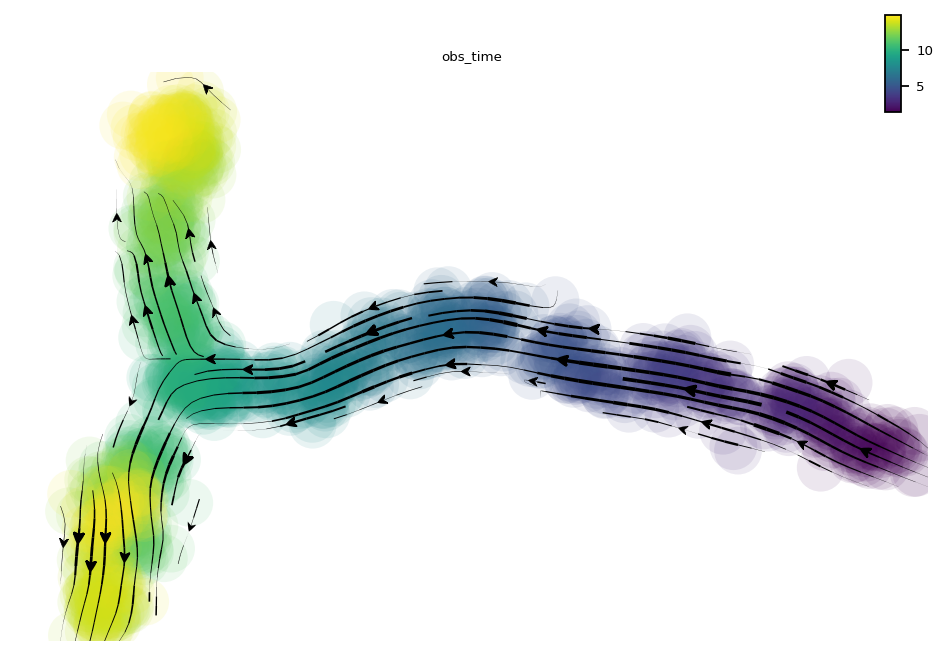

In [15]:
# storm
dyn.pl.streamline_plot(adata_storm, color='obs_time', basis='pca',
                       save_show_or_return='show', save_kwargs={'prefix': 'sim_2branch_pca_storm', 'ext': 'png',
                        "bbox_inches": None, 'dpi': dpi, 'path': path}, figsize=figsize
                       )

<Figure size 600x400 with 0 Axes>

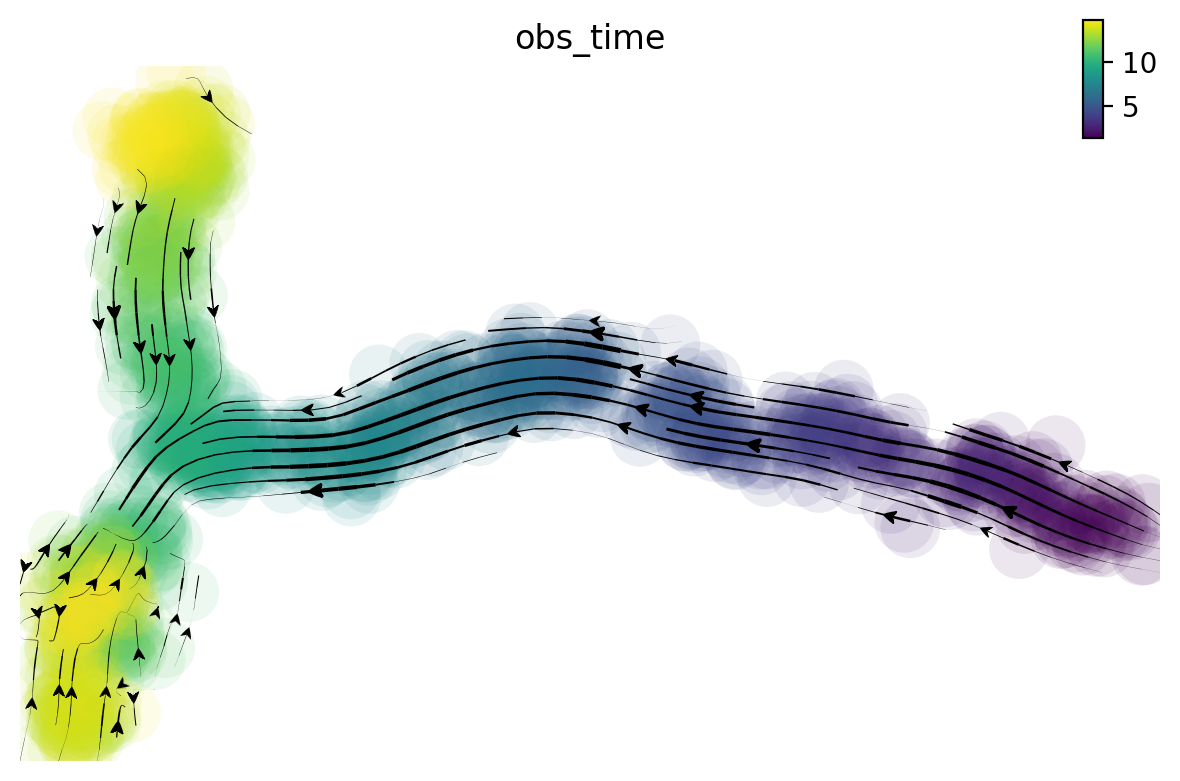

In [16]:
# dynamo
dyn.pl.streamline_plot(adata_dynamo, color='obs_time', basis='pca',
                       save_show_or_return='show', save_kwargs={'prefix': 'sim_2branch_pca_dynamo', 'ext': 'png',
                        "bbox_inches": None, 'dpi': dpi, 'path': path}, figsize=figsize
                       )

<Figure size 600x400 with 0 Axes>

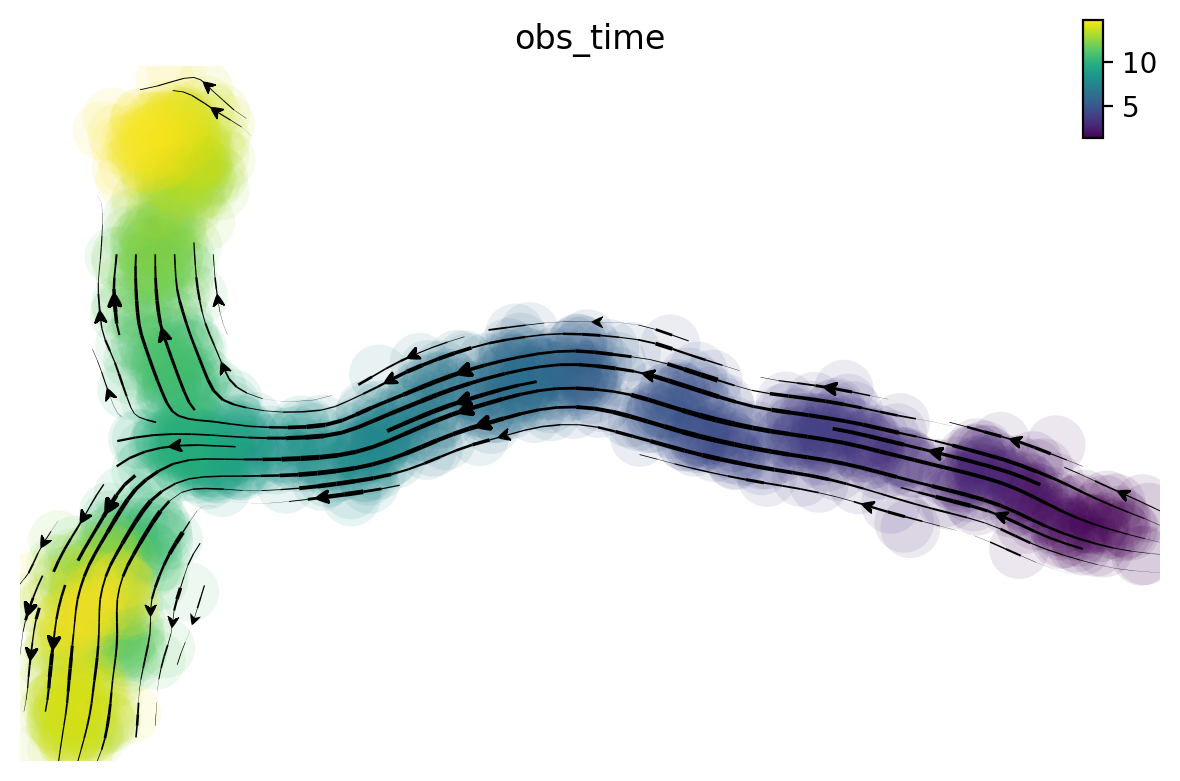

In [17]:
# celldancer
dyn.pl.streamline_plot(adata_celldancer, color='obs_time', basis='pca',
                       save_show_or_return='show', save_kwargs={'prefix': 'sim_2branch_pca_celldancer', 'ext': 'png',
                        "bbox_inches": None, 'dpi': dpi, 'path': path}, figsize=figsize
                       )

### Compare the degradation rate $\gamma_{s}$ of each method with the ground truth

In [18]:
gamma_storm = adata_storm[:,adata_storm.var.use_for_pca].var['gamma'].values
gamma_dynamo = adata_dynamo[:,adata_dynamo.var.use_for_pca].var['gamma'].values
# gamma_scvelo = adata_scvelo[:,adata_scvelo.var.use_for_pca].var['fit_gamma'].values
gamma_celldancer = np.mean(adata_celldancer.layers['gamma'], axis = 0)
gamma_gt = gamma[adata_storm.var.use_for_pca]

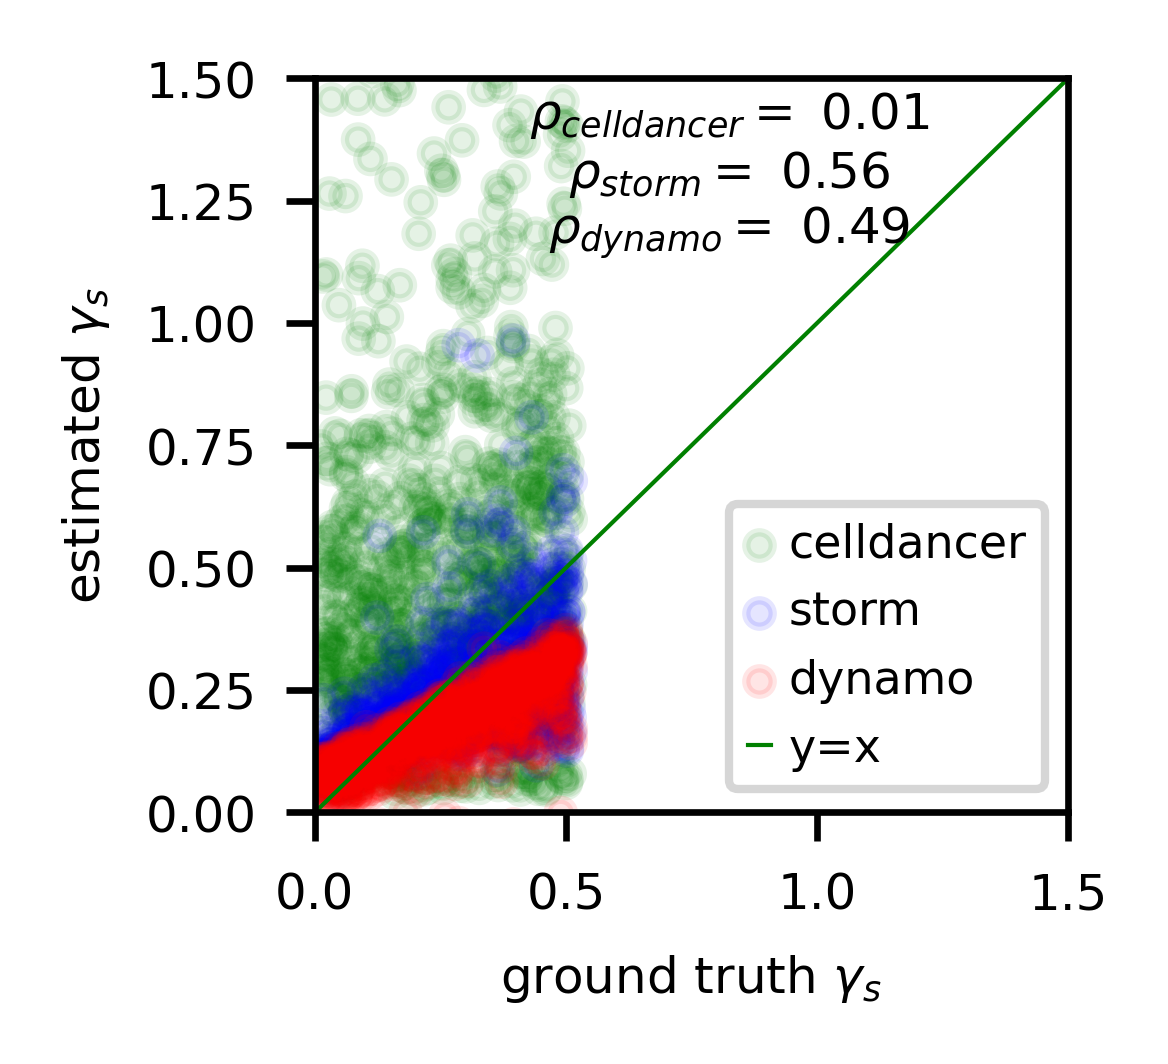

In [19]:
sc.set_figure_params(scanpy=True, fontsize=6)
scatter_size = 10
figsize = (1.61, 1.61)
alpha = 0.1
dpi = 300

gamma_storm = gamma_storm.astype('float')
gamma_dynamo = gamma_dynamo.astype('float')
# gamma_scvelo = gamma_scvelo.astype('float')
gamma_celldancer = gamma_celldancer.astype('float')

range_min = 0
range_max = 1.5
x = np.arange(range_min, range_max, 0.01)
y = x

index_no_nan = np.logical_and(np.isfinite(gamma_storm), np.isfinite(gamma_dynamo))
# index_no_nan = np.logical_and(index_no_nan, np.isfinite(gamma_scvelo))
index_no_nan = np.logical_and(index_no_nan, np.isfinite(gamma_celldancer))

# correlation coefficient between all the genes
rho_storm = np.corrcoef(gamma_storm[index_no_nan], gamma_gt[index_no_nan])
rho_dynamo = np.corrcoef(gamma_dynamo[index_no_nan], gamma_gt[index_no_nan])
# rho_scvelo = np.corrcoef(gamma_scvelo[index_no_nan], gamma_gt[index_no_nan])
rho_celldancer = np.corrcoef(gamma_celldancer[index_no_nan], gamma_gt[index_no_nan])


fig = plt.figure(1, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
# ax.scatter(gamma_gt, gamma_scvelo, color='orange', s=scatter_size * np.ones(len(gamma_scvelo)), 
#            alpha=alpha, label = 'scvelo')
ax.scatter(gamma_gt, gamma_celldancer, color='green', s=scatter_size * np.ones(len(gamma_dynamo)), 
           alpha=alpha, label = 'celldancer')
ax.scatter(gamma_gt, gamma_storm, color='blue', s=scatter_size * np.ones(len(gamma_storm)), 
           alpha=alpha, label = 'storm')
ax.scatter(gamma_gt, gamma_dynamo, color='red', s=scatter_size * np.ones(len(gamma_dynamo)), 
           alpha=alpha, label = 'dynamo')
ax.plot(x, y, color='g', linewidth=0.5, label='y=x')
# plt.text(0.9, 0.75, 'y=x', ha='center', va='center', transform=ax.transAxes, color='g')
# plt.text(0.55, 0.95, '$\\rho_{scvelo}=$ %4.2f' % rho_scvelo[0][1], 
#          ha='center', va='center', transform=ax.transAxes, color='black')
plt.text(0.55, 0.95, '$\\rho_{celldancer}=$ %4.2f' % rho_celldancer[0][1], 
         ha='center', va='center', transform=ax.transAxes, color='black')
plt.text(0.55, 0.87, '$\\rho_{storm}=$ %4.2f' % rho_storm[0][1], 
         ha='center', va='center', transform=ax.transAxes, color='black')
plt.text(0.55, 0.79, '$\\rho_{dynamo}=$ %4.2f' % rho_dynamo[0][1], 
         ha='center', va='center', transform=ax.transAxes, color='black')
plt.xlabel('ground truth $\gamma_s$ ')
plt.ylabel('estimated $\gamma_s$')
plt.xlim(0,1.5)
plt.ylim(0,1.5)
plt.legend()
plt.grid(False)
# plt.savefig('./rev_figures/figure3/comp/sim_2branch_scatter.pdf',dpi=dpi, bbox_inches="tight")
plt.show()

Plot the distribution of the difference between the estimate and the true value

In [20]:
import seaborn as sns

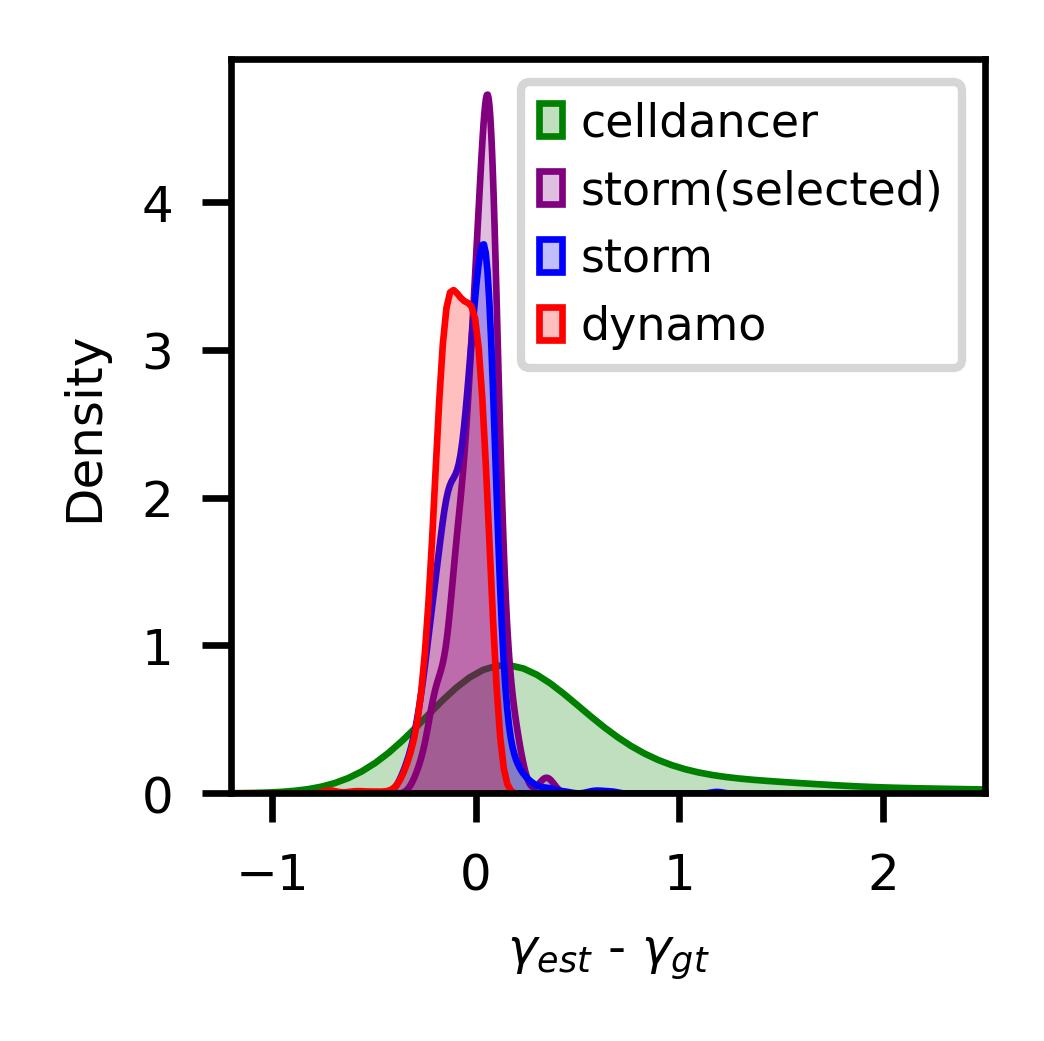

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.validation_loss_df = self.validation_loss_df.append(loss_df)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/sampling.py:252: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df_downsampled=data_df_downsampled.append(data_df_one_gene_downsampled)
/home/pqw/anaconda3/envs/WD/lib/python3.8/site-packages/celldancer/velocity_estimation.py:417: FutureWarning: Th

In [28]:
index_storm_well_fitted = np.logical_and(adata_storm[:, adata_storm.var.use_for_pca].var['no_linear_r2'] > r2_thr, 
                                         adata_storm[:, adata_storm.var.use_for_pca].var['gamma_r2'] > 0)
fig = plt.figure(2, figsize=figsize, dpi=dpi)
ax = fig.add_subplot(111)
# sns.kdeplot(gamma_scvelo - gamma_gt, 
#            shade=True, ax=ax, color='orange', label='scvelo', linewidth=0.8)
sns.kdeplot(gamma_celldancer - gamma_gt, 
            shade=True, ax=ax, color='green', label='celldancer', linewidth=0.8)
sns.kdeplot(gamma_storm[index_storm_well_fitted] - gamma_gt[index_storm_well_fitted], 
            shade=True, ax=ax, color='purple', label='storm(selected)', linewidth=0.8)
sns.kdeplot(gamma_storm - gamma_gt, 
            shade=True, ax=ax, color='blue', label='storm', linewidth=0.8)
sns.kdeplot(gamma_dynamo - gamma_gt, 
            shade=True, ax=ax, color='red', label='dynamo', linewidth=0.8)
plt.xlabel('$\gamma_{est}$ - $\gamma_{gt}$')
plt.legend()
plt.grid(False)
plt.xlim(-1.2,2.5)
# plt.savefig('./rev_figures/figure3/comp/sim_2branch_kdeplot.pdf', dpi=dpi, bbox_inches="tight")
plt.show()

### Compare the transcription rate $\alpha$ of each method with the ground truth

In [22]:
alpha_storm = adata_storm[:,adata_storm.var.use_for_pca].layers['cell_wise_alpha'].A
k = 1 - np.exp(-gamma_dynamo[:, None] * labeling_time[None, :])
alpha_dynamo = csr_matrix(gamma_dynamo[:, None]).multiply(adata_dynamo[:, adata_dynamo.var.use_for_pca].layers['M_n'].T).multiply(1 / k).T.A
alpha_celldancer = adata_celldancer.layers['alpha']
alpha_gt = adata_storm[:,adata_storm.var.use_for_pca].layers['true_alpha']

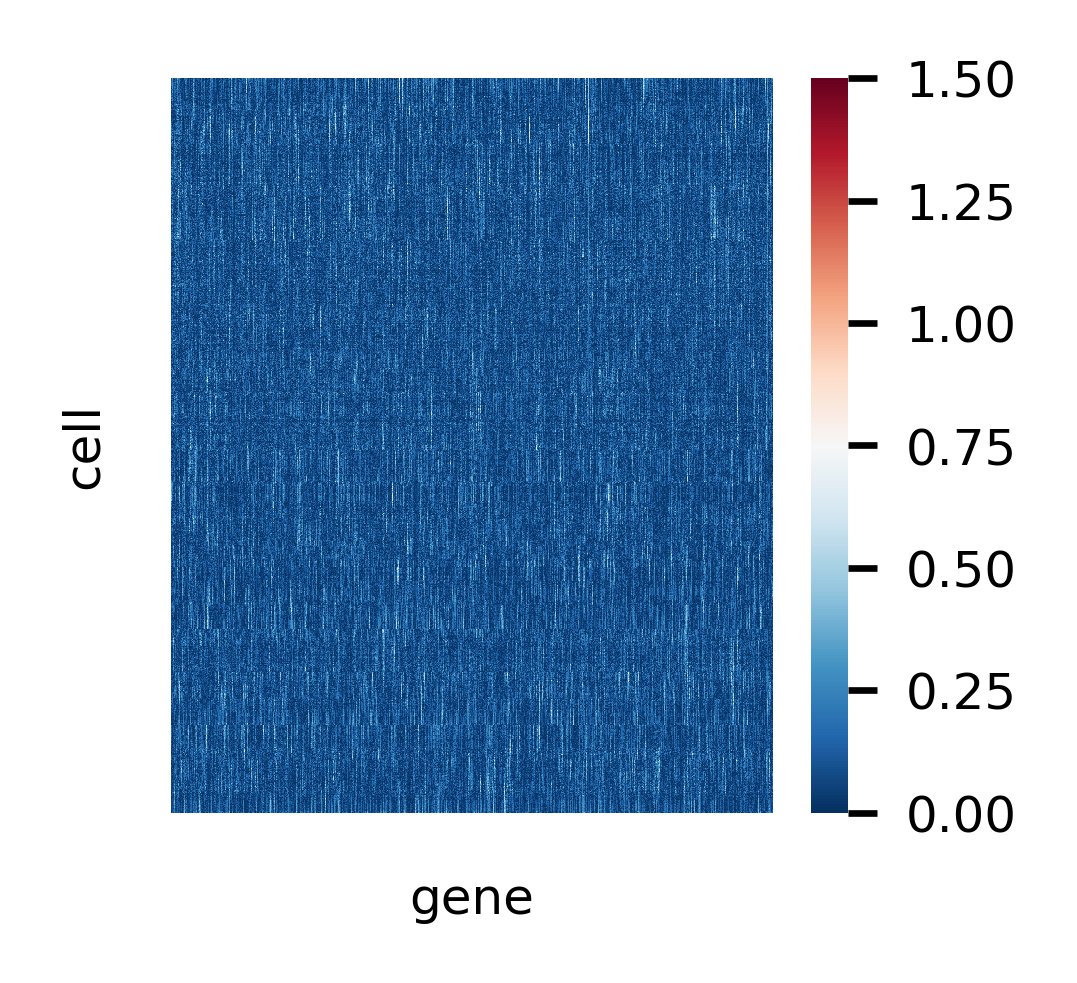

In [23]:
# storm
fig = plt.figure(4, figsize=figsize, dpi=dpi)
sns.heatmap(data=np.abs(alpha_gt[:, index_no_nan]-alpha_storm[:, index_no_nan]),cmap="RdBu_r", vmin=0.0, vmax=1.5, xticklabels=False, yticklabels=False)
plt.xlabel('gene')
plt.ylabel('cell')
# plt.savefig('./rev_figures/figure3/comp/sim_2branch_alpha_heatmap_storm.png', dpi=dpi, bbox_inches="tight")
plt.show()

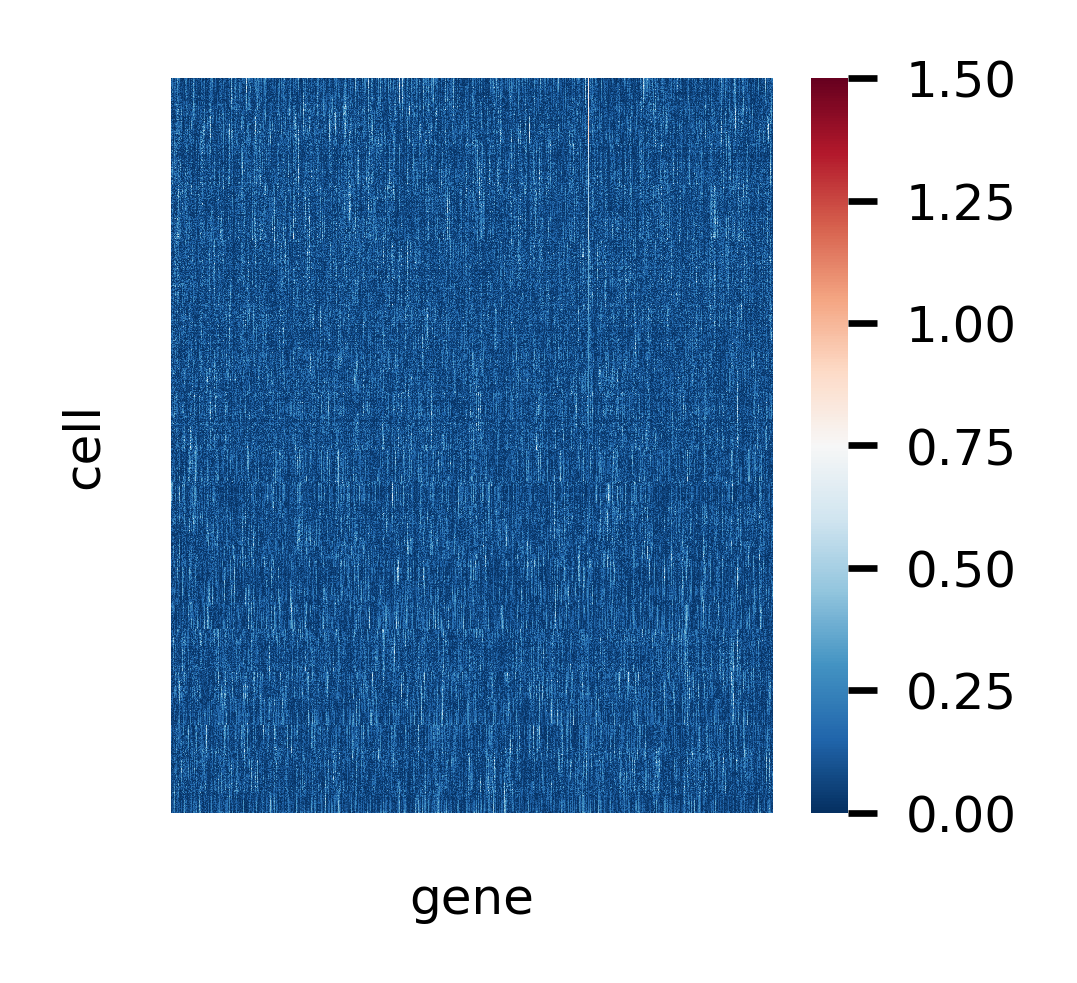

In [24]:
# dynamo
fig = plt.figure(5, figsize=figsize, dpi=dpi)
sns.heatmap(data=np.abs(alpha_gt[:, index_no_nan] - alpha_dynamo[:, index_no_nan]),cmap="RdBu_r", vmin=0.0, vmax=1.5, xticklabels=False, yticklabels=False)
plt.xlabel('gene')
plt.ylabel('cell')
# plt.savefig('./rev_figures/figure3/comp/sim_2branch_alpha_heatmap_dynamo.png', dpi=dpi, bbox_inches="tight")
plt.show()

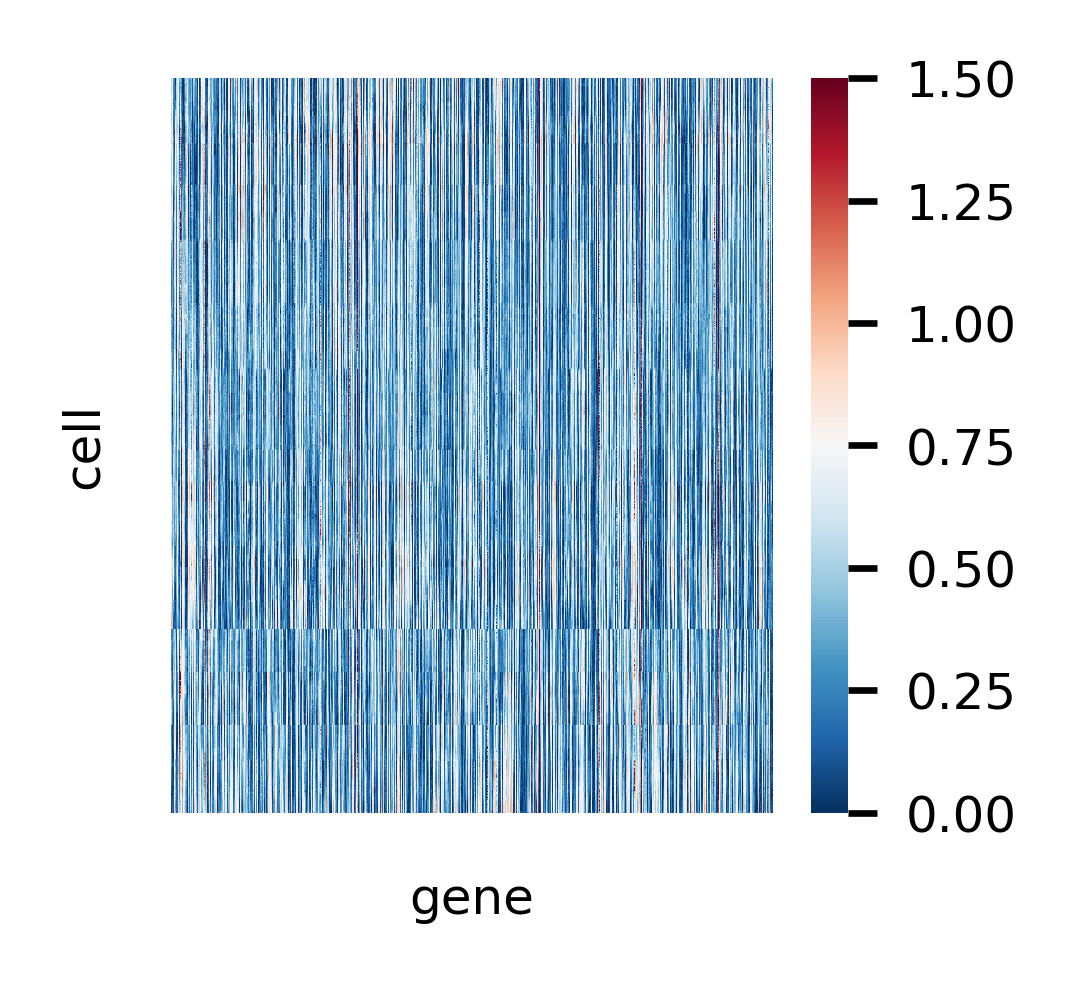

In [25]:
# celldancer
fig = plt.figure(6, figsize=figsize, dpi=dpi)
sns.heatmap(data=np.abs(alpha_gt[:, index_no_nan] - alpha_celldancer[:, index_no_nan]),cmap="RdBu_r", vmin=0.0, vmax=1.5, xticklabels=False, yticklabels=False)
plt.xlabel('gene')
plt.ylabel('cell')
# plt.savefig('./rev_figures/figure3/comp/sim_2branch_alpha_heatmap_celldancer.png', dpi=dpi, bbox_inches="tight")
plt.show()